## Zero-Shot Learning

Zero-shot learning is **a recently new type of learning** that aims to **recognize classes that have not been seen during training**. 
This is a very important task as it allows the model to generalize to new classes without the need to re-train the model.

### Motivation for Zero-Shot Learning

One of the core problems in ML is the **lack of labeled examples for a given task**.

Almost every interesting task in industry requires supervised data:

* Sentiment analysis: positive and negative examples.
* Recommendation systems: ranking of the item: ⭐️⭐️⭐️⭐️
* Image classification: the classes of the objects:🐶 (dog), 🐱(cat), 👩 (person)

**What can you do if you don’t have an annotated dataset?**

Human annotation & crowdsourcing:
* Expensive (both in € and hours)
* Boring
* Doesn’t scale very well

In this class, we will focus on a recent alternative, **zero-shot learning, which allows us to recognize classes that have not been seen during training.**



### The CLIP architecture (OpenAI, 2021)

* This is the most popular model to perform zero-shot classification tasks with image data.

* It was trained over 400M pairs of (image, caption) from the internet.

* CLIP consists in two neural networks: a vision network (like what we saw in previous classes) and a language network (to understand texts).


Further read: https://openai.com/research/clip

**Exercise** Before we see the details of CLIP, try this online demo to perform zero-shot image classification using CLIP:

https://huggingface.co/spaces/Gosula/Clip_model

![image](images/clip_demo.png)

### Details of CLIP

Each of its two neural networks, **converts the image (resp. the text) into a 512-dimensional (semantic) vector**.

Similarly to what we did in transfer learning, **this vector is a compact representation of the image**. And the same for the text.

$$
I = NN_1(IMAGE)
$$
$$
T = NN_2(TEXT)
$$

So, $I$ and $T$ are 512-dimensional vectors.


Next, we can compute a score, called **similarity score**, to check whether these two vectors are close or not.

**Question**: How can we measure if two vectors are close or not in the space?

With CLIP, we use the **cosine similarity**, which measures the cosine of the angle between two vectors:

![image](images/cosine.jpeg)

In the end, **it's just the scalar product of the two vectors, after they are normalized by their norms.**

If they are pretty close, the **cosine similarity** will be close to 1. If they are far, the **cosine similarity** will be close to 0.

#### Doing zero-shot classification with CLIP

1. Compute the vector representation ($I$) of the image.
2. Compute the vector representations ($T_1$, $T_2$, ...) for each of the text labels.
3. Compute the cosine similarity between $I$ and each of the $T_i$.
4. The **class with the highest similarity score is the predicted label**.

![image](images/clip.png)

### Using CLIP from pytorch

The model class and weights are available at

https://github.com/openai/CLIP

you need to install it with

```bash
pip install git+https://github.com/openai/CLIP.git
```

Then, the code is very simple:

Let's go step by step!

In [1]:
import torch
import clip
from PIL import Image

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


We load the model. "VIT-B/32" stands for the size, as there are different sizes of the model (more on that later).

The first time you run this code, the model will be downloaded to your computer.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Now, let's choose an image to classify it

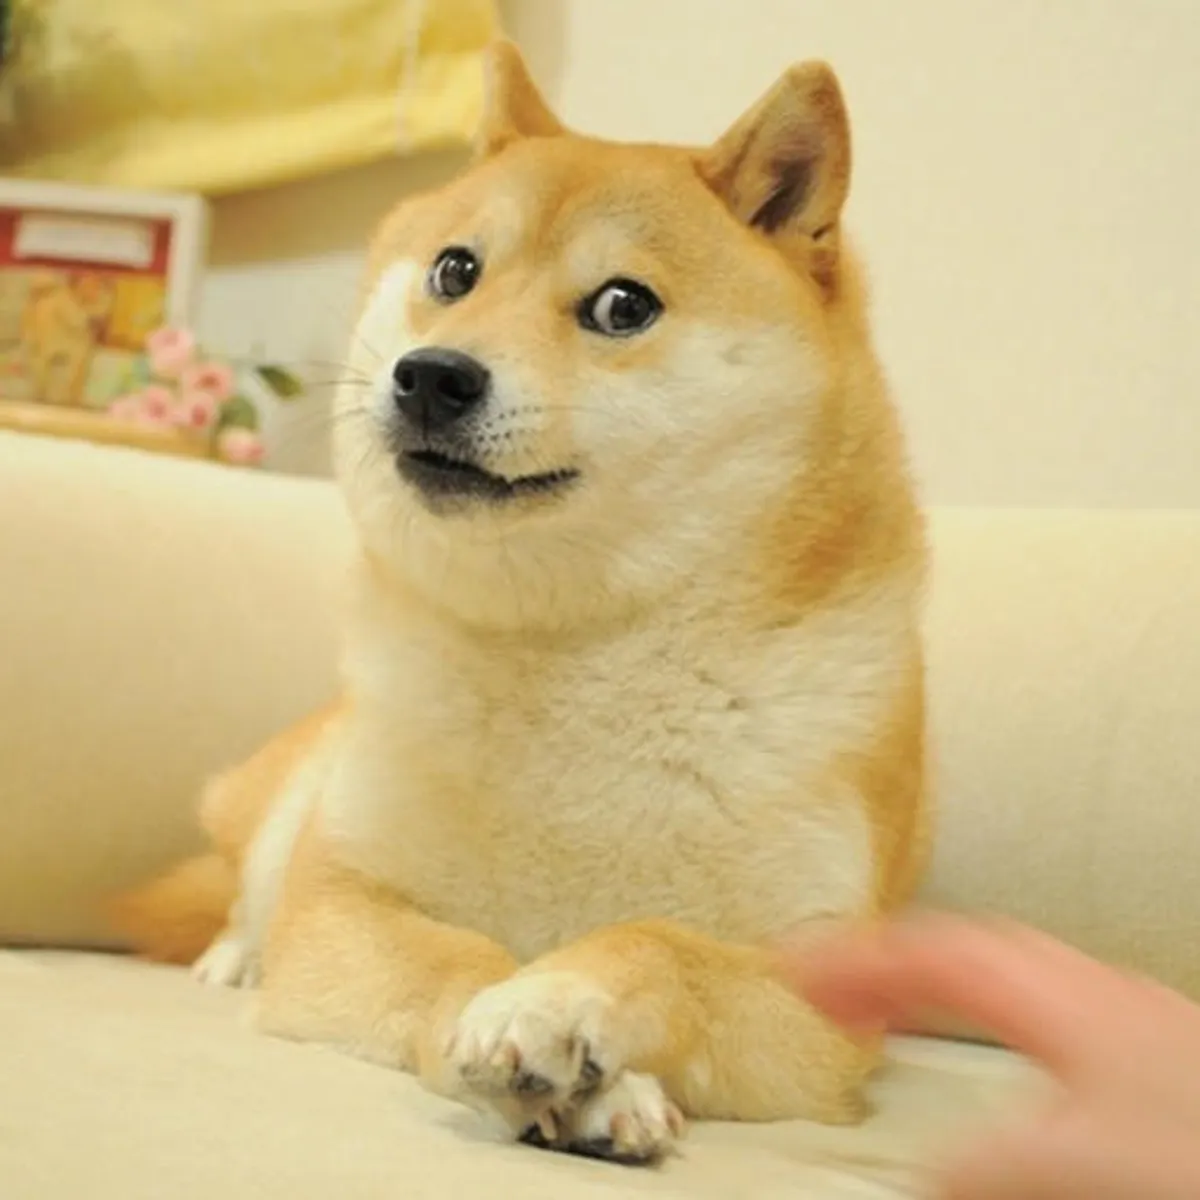

In [3]:
image = Image.open("images/shiba.png")
image

We convert the image to a tensor (this is not yet the final vector representation of the image!!).

This is just a standard preprocessing step, so every image has the same size.

In [4]:
image = preprocess(image).unsqueeze(0).to(device)

In [5]:
image.shape

torch.Size([1, 3, 224, 224])

Next, we specify the labels we want to classify

In [6]:
labels = ["a cat", "a dog"]
text = clip.tokenize(labels).to(device)

Now, we can compute the vector representation of both image and texts:

In [7]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

Notice the shapes:

In [8]:
image_features.shape

torch.Size([1, 512])

In [45]:
text_features.shape

torch.Size([2, 512])

Now, we can compute the cosine similarity between the image and the texts:

In [9]:
# Normalize first, dividing by the norm of each vector
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity
similarity = image_features @ text_features.T

In [10]:
similarity

tensor([[0.2331, 0.2768]])

**Question**: According to each similarity, which label is closest to the image?

We can convert the similarity scores to probabilities, using the softmax function:

(First, we multiply the scores by 100, as this is a factor that they used during the CLIP pre-training)

In [11]:
probabilities = (100*similarity).softmax(dim=-1)
probabilities

tensor([[0.0125, 0.9875]])

In [12]:
for i, label in enumerate(labels):
    print(f"{label}: {100*probabilities[0, i].item():.2f}%")

a cat: 1.25%
a dog: 98.75%


**The advantage of zero-shot classification, is that we can change the labels without changing the model.**

In [13]:
labels = ["a cat", "a dog", "a human", "a document"]
text = clip.tokenize(labels).to(device)

# Calculate features (only for the text, since we have the same image)
with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity
similarity = image_features @ text_features.T

probabilities = (100.*similarity).softmax(dim=-1)

for i, label in enumerate(labels):
    print(f"{label}: {100*probabilities[0, i].item():.2f}%")

a cat: 1.22%
a dog: 96.40%
a human: 1.95%
a document: 0.43%


A more  complex classification task...

In [14]:
labels = ["French bulldog", "Siberian husky", "Shiba Inu", "Golden Retriever", "Yorkshire", "Spanish hound"]

text = clip.tokenize(labels).to(device)

# Calculate features (only for the text, since we have the same image)
with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity
similarity = image_features @ text_features.T

probabilities = (100.*similarity).softmax(dim=-1)

for i, label in enumerate(labels):
    print(f"{label}: {100*probabilities[0, i].item():.2f}%")

French bulldog: 0.03%
Siberian husky: 0.16%
Shiba Inu: 99.45%
Golden Retriever: 0.28%
Yorkshire: 0.00%
Spanish hound: 0.07%


Note that the classification text prompts can be as long and complex as we want!

In [15]:
labels = ["A photo of a dog", "A pencil drawing of a dog"]

text = clip.tokenize(labels).to(device)

# Calculate features (only for the text, since we have the same image)
with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity
similarity = image_features @ text_features.T

probabilities = (100.*similarity).softmax(dim=-1)

for i, label in enumerate(labels):
    print(f"{label}: {100*probabilities[0, i].item():.2f}%")

A photo of a dog: 99.93%
A pencil drawing of a dog: 0.07%


**Exercise** Create a Python function that receives an image path and a list of labels, and returns the probabilities.

Test over more examples

**Exercise** Brainstorm a series of text prompts that could be useful for an image classification task (think of a business application, a hobby, etc).

Demonstrate your approach with a few image examples.

### Summary

Zero-shot classification is a recent, very powerful learning paradigm. But it has some trade-offs:

#### Advantages

* No need to re-train the model for new classes: easy and quick to build applications or adapt to new classes.

#### Disadvantages

* The model may be not as accurate as a model trained with the specific classes by transfer learning, even when just using a few labelled examples.

* CLIP inference is more costly (in time and memory) than a specialized neural network for a specific task.

### Fine-tuning (transfer learning) from CLIP

As we did in the previous notebooks, the CLIP model can be fine-tuned for a specific task, if we have a few labeled examples.

Here is an example of fine-tuning CLIP for the FashionMNIST dataset, by learning a logistic regression on top of the CLIP vectors

(The code is going to take a while to run...).

In [ ]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100, FashionMNIST
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = FashionMNIST(root, download=True, train=True, transform=preprocess)
test = FashionMNIST(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)


    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

In [ ]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, max_iter=1000)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")